# Importing the dataset and necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
medical_df = pd.read_csv('C:/Users/sogor/OneDrive/Documents/DataScientist_practice/datasets/medical_insurance.csv')

In [3]:
medical_df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

My objective is to find a way to estimate the value in the "charges" column (in this case the target variable) using other features from this dataset.

In [4]:
# Verifying the number of records and columns from my dataset, also my variables and their data type.
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: >

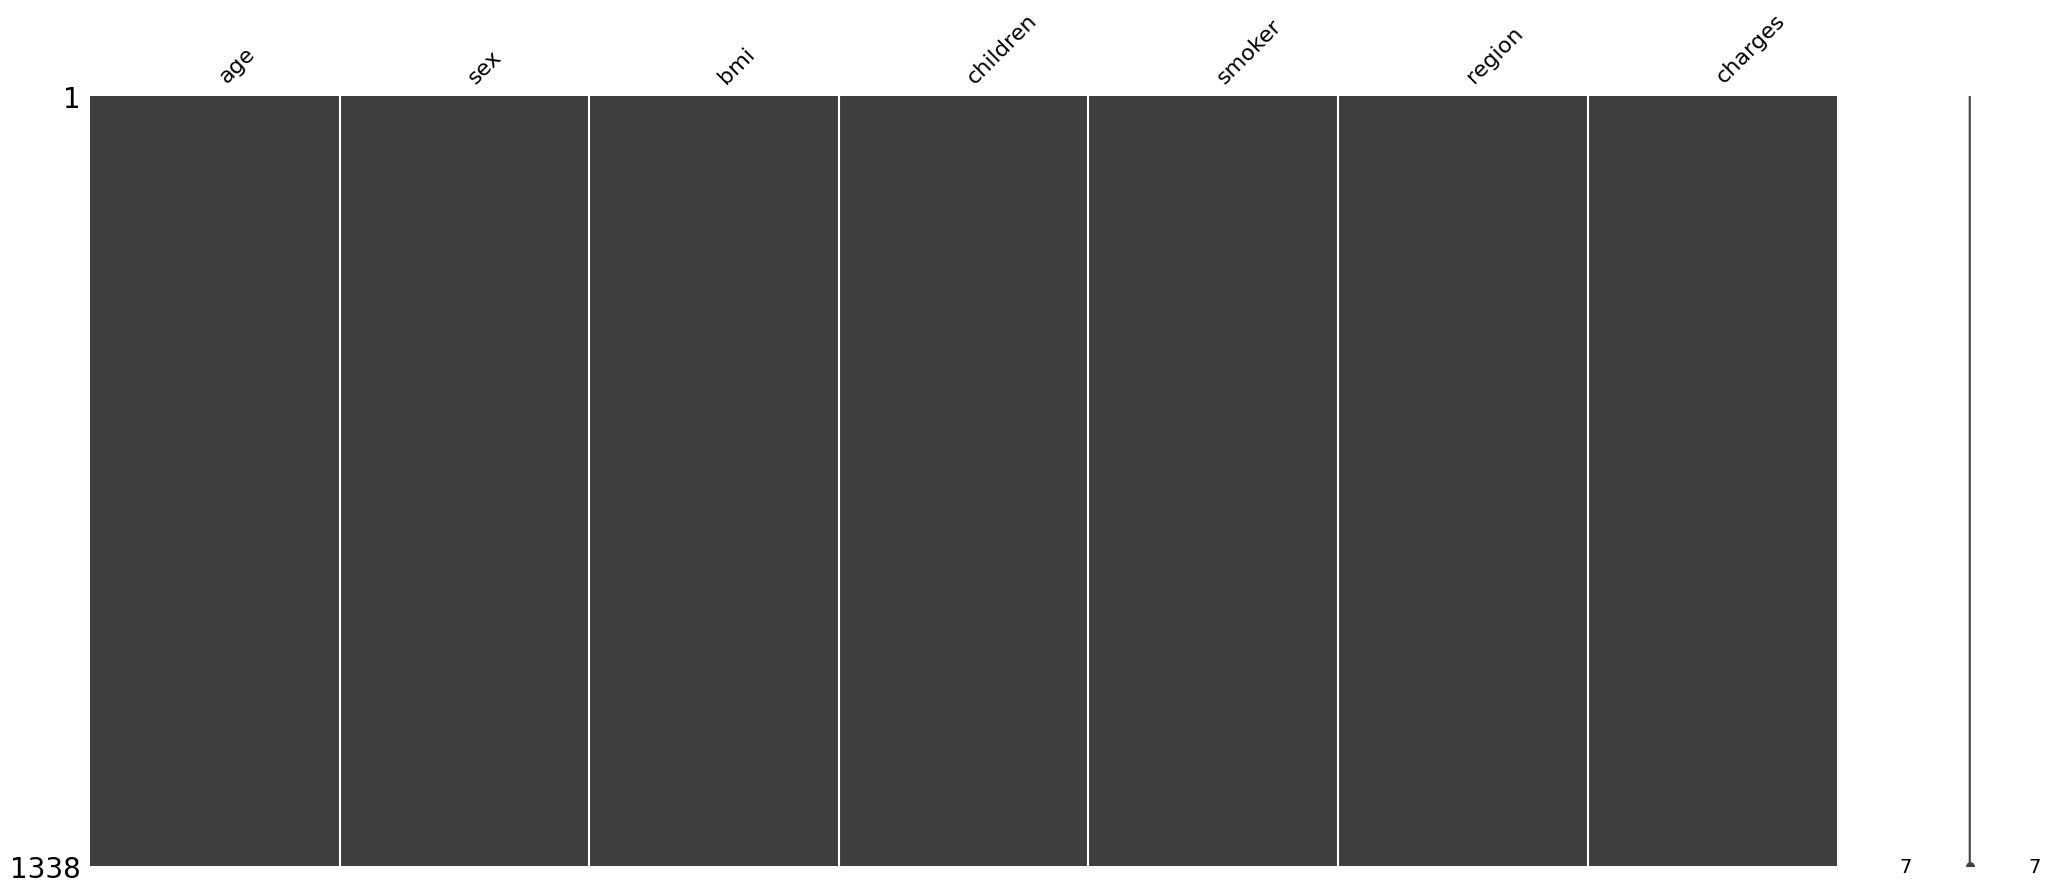

In [5]:
msno.matrix(medical_df)

In [6]:
print("Number of duplicates:", medical_df.duplicated().sum())

Number of duplicates: 1


In [7]:
# Remove duplicates from the DataFrame
medical_df = medical_df.drop_duplicates()

# Verify that duplicates are removed
print("Number of duplicates after removal:", medical_df.duplicated().sum())

Number of duplicates after removal: 0


Looks like none of the columns contain any missing values, which is awesome!

In [8]:
#Quick statistical overview 
medical_df.describe()

age          bmi     children       charges
count  1337.000000  1337.000000  1337.000000   1337.000000
mean     39.222139    30.663452     1.095737  13279.121487
std      14.044333     6.100468     1.205571  12110.359656
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.290000     0.000000   4746.344000
50%      39.000000    30.400000     1.000000   9386.161300
75%      51.000000    34.700000     2.000000  16657.717450
max      64.000000    53.130000     5.000000  63770.428010

As a conclusion:
- The range of values in numerical columns seems reasonable, there are no negative bmi, age, number of children or even negative charge given.
- The "charges" column seems to be skewed, due to the fact that the median (or also known as 50 percentile) is much lower than the maximum value. We will probably see those outliers in the upcoming visualizations.

# Exploratory Data Analysis 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline 

In [10]:
# I change the default style and font size for my charts
import matplotlib

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

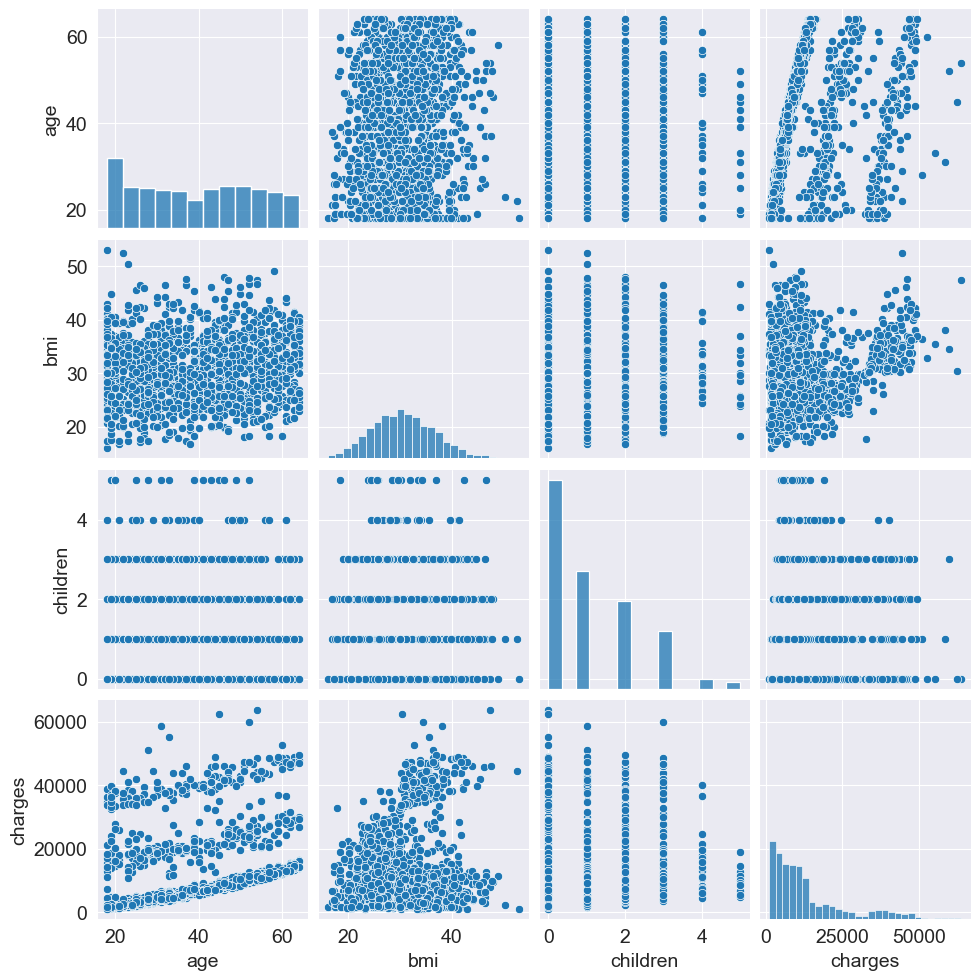

In [11]:
sns.pairplot(medical_df)
plt.show()

It provides a quick overview of the relationships between pairs of variables in the dataset. Each scatter plot in the pair plot represents the relationship between two variables, and diagonal plots show the distribution of individual variables. Pair plots can also help detect data quality issues such as missing values, outliers, or data distributions that are not as expected. They are helpful in deciding which variables to include in further analysis. 

In [12]:
fig = px.histogram(medical_df, 
                   x = 'age',
                  marginal = 'box', # display the box-plot above
                  nbins = 47, # I use 47 bins which includes ages ranging from 18 to 64
                  title = 'Distribution of Age')
fig.update_layout(bargap = .1) # settig a little gap between the bars
fig.show()

This is almost a nice uniform distribution, except for the beginning, where we see a concentration of customers between the ages of 18 and 19. The reason behind could be: as many customers aged 18 and 19 compared to other age groups may be that the insurance company offers lower rates to young adults. Alternatively, it could be because 18 is the legal age to obtain insurance, so as soon as they turn 18, individuals get insured.

In [13]:
fig2 = px.histogram(medical_df,
                   x = 'bmi',
                   marginal = 'box',
                   color_discrete_sequence = ['green'],
                   title = 'Distribution of Body Mass Index (BMI)'
                   )
fig2.show()

The BMI index seems to form a Gaussian distribution (or also called Normal distribution) centered around the value 30.

In [14]:
fig3 = px.histogram(medical_df,
                   x = 'charges',
                   marginal = 'box',
                   color = 'smoker',
                   color_discrete_sequence = ['#41C9E2', '#FF5BAE'],
                   title = 'Distribution of Medical Charges by Smoking Status')
fig3.show()

We can make the following observation:
- This follows the exponential distribution, we have a lot of people with a low charge expense.
- There is a significant difference between the smokers and non-smokers, because the median for smokers is almost five times more than in case of non-smokers.
- For most customers the annual medical charges are under $10 000 and only a small fraction of people have a higher medical expenses, possibly because they suffer from a major illnesses.

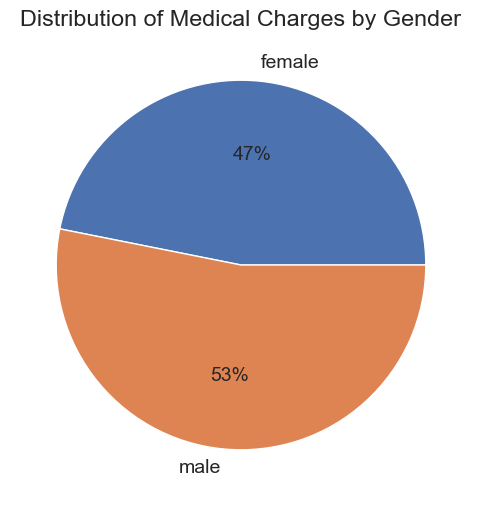

In [15]:
# Extract relevant data (assuming 'charges' and 'sex' columns exist)
charges_by_sex = medical_df.groupby('sex')['charges'].sum()

palette_color = sns.color_palette('deep')
plt.figure(figsize=(6, 6))

plt.pie(charges_by_sex, labels = charges_by_sex.index, colors = palette_color, autopct = '%.0f%%')

plt.title('Distribution of Medical Charges by Gender')
plt.show()

There is not a huge significant difference between the gender of the people regarding the charges.

In [16]:
fig4 = px.histogram(medical_df,
                   x = 'charges',
                   marginal = 'box',
                   color = 'sex',
                   color_discrete_sequence = ['#9F70FD', '#FDA403'],
                   title = 'Distribution of Medical Charges by Gender')
fig4.show()

This illustrates well, that within every charge range men pay more than women.

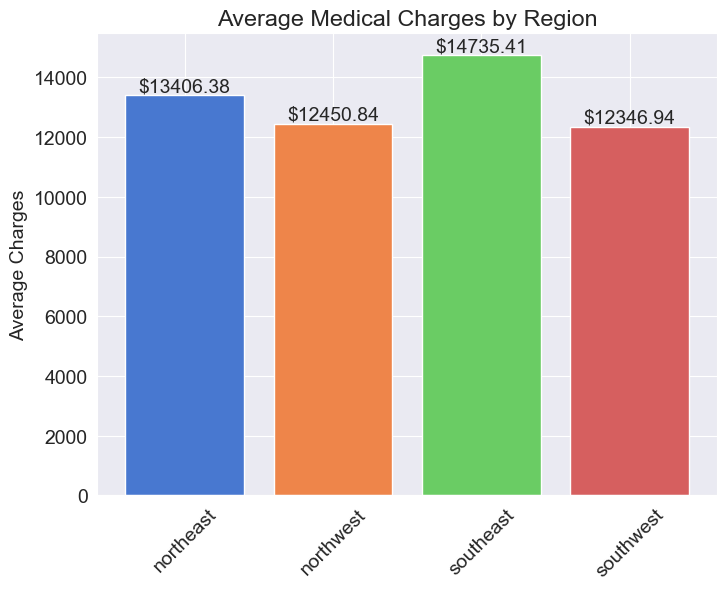

In [17]:
# Calculate the average charges by region
charges_by_region = medical_df.groupby('region')['charges'].mean()

palette_color = sns.color_palette('muted')

plt.figure(figsize=(8, 6))
bars = plt.bar(charges_by_region.index, charges_by_region, color = palette_color)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"${height:.2f}", ha = 'center', va = 'bottom')

plt.ylabel("Average Charges")
plt.title("Average Medical Charges by Region")
plt.xticks(rotation = 45)
plt.show()

People from the Southeast region pay higher charges on average. In the Southwest and Northwest, the values are almost similar, while in the Northeast, it falls between these two extremes.

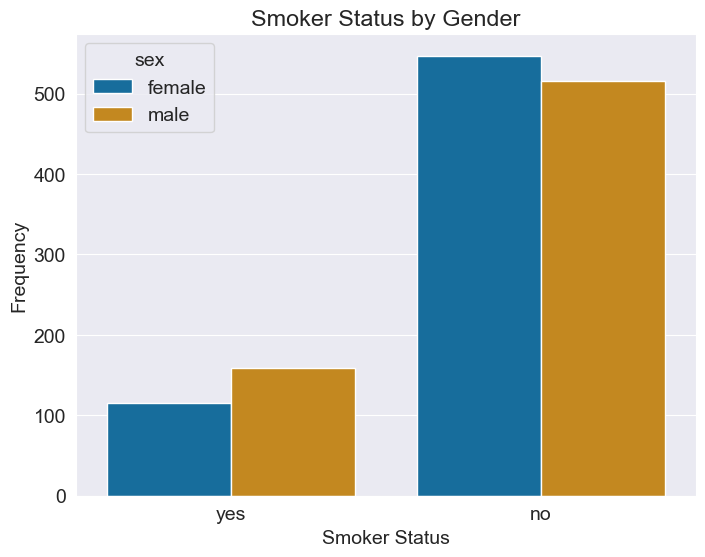

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(data = medical_df, x = 'smoker', hue = 'sex', palette = 'colorblind')
plt.xlabel('Smoker Status')
plt.ylabel('Frequency')
plt.title('Smoker Status by Gender')
plt.show()

We can draw the conclusion: Smoking is more common habit among males.

In [19]:
fig5 = px.scatter(medical_df,
                 x = 'age',
                 y = 'charges',
                 color = 'smoker',
                 hover_data = ['sex'],
                 opacity = 0.8,  # for better seeing the data because of overlapping
                 title = 'Age vs Charges')
fig5.show()

- The general trend seems to be that medical charges increase with age, as we might expect. But age alone can not be used to determine medical charges.
We can observe 3 clusters, each with an increasing slope:
1. The first consist of "non-smoker" who have relatively low medical charges.
2. The second cluster contains a mix of "smokers" and "non-smokers". Perhaps actually we see two distinct but overlapping clusters.
3. In the third cluster there are exclusively "smokers", probably with major illnesses caused by smoking.

In [20]:
fig5 = px.scatter(medical_df,
                 x = 'age',
                 y = 'charges',
                 color = 'region',
                 hover_data = ['sex'],
                 opacity = 0.6,  # for better seeing the data because of overlapping
                 title = 'The variety of medical charges with age across different regions')
fig5.show()

I can't notice a significant difference between the variety of medical charges with age across the regions. There are some outliers in each region, but it looks similar the spread of their occurrence.  

In [21]:
fig6 = px.scatter(medical_df,
                 x = 'bmi',
                 y = 'charges',
                 color = 'smoker',
                 hover_data = ['sex'],
                 opacity = 0.6,  # for better seeing the data because of overlapping
                 title = 'Relationship between the BMI and Charges')
fig6.show()

This graph represents the fact that in case of "non-smokers" an increase in BMI doesn't seems to be related to an increase in medical charges. However medical charges are higher for smokers when the BMI also grows.

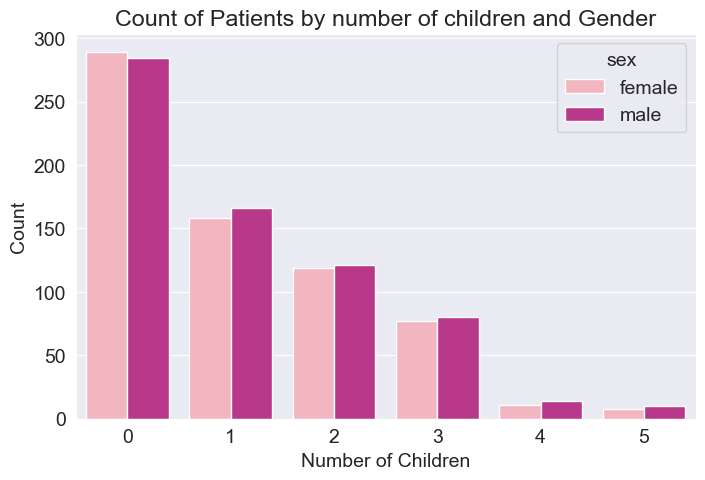

In [22]:
plt.figure(figsize=(8, 5))
sns.countplot(data = medical_df, x = 'children', hue = 'sex', palette = 'RdPu')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.title('Count of Patients by number of children and Gender')
plt.show()

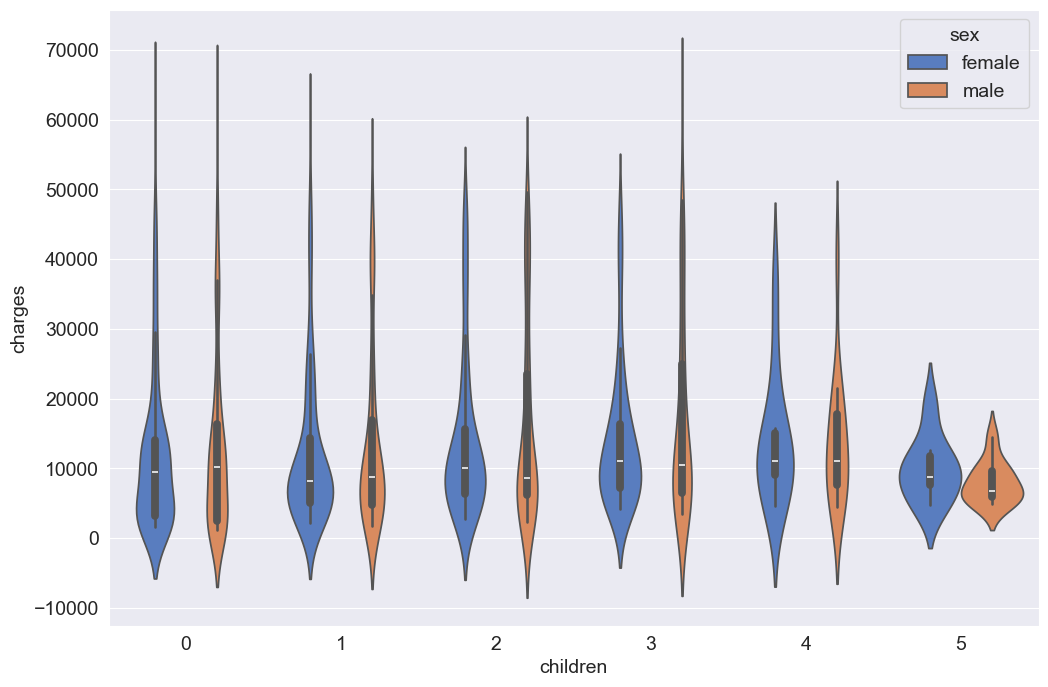

In [23]:
sns.violinplot(data = medical_df, x = 'children', y = 'charges', hue = 'sex', palette = 'muted', inner = 'box')
plt.show()

Here are the takeaways:
- As the number of children increases to two or three, the charges show a gradual rise.
- For individuals with four or five children, the charges are slightly lower again, I assume is because they are supported by the government.

In [24]:
# To make a correlation matrix for categorical columns, they must be first converted into numeric columns.
smoking_to_numeric = {"yes" : 1, "no" : 0}
smoking = medical_df.smoker.map(smoking_to_numeric)

In [25]:
numerical_columns = medical_df.select_dtypes(exclude = 'object')
categorical_columns = medical_df.select_dtypes(include = 'object')

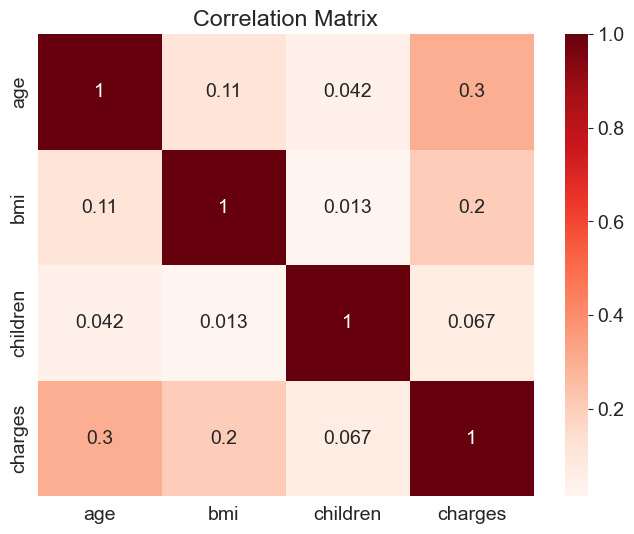

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_columns.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix')
plt.show()

Correlation can be interpreted by the strength and direction <=> 
- The greater the absolute value of the correlation efficient, the stronger the relationship, it can take values from [-1,1].
- The sign of correlation coefficient represents the direction of the relationship. This coefficient can be positive or negative.

Here are the key takeaways regarding on our target variable (charges):

- Age and Charges: There is a moderate positive correlation (0.3) between age and charges. As age increases, medical charges tend to rise.
- BMI and Charges: Similarly, there is another moderate positive correlation (0.3) between BMI (body mass index) and charges. Higher BMI is associated with higher medical costs.
- Children and Charges: The correlation between the number of children and charges is weak (0.013), suggesting that having more children doesn’t significantly impact medical expenses.

## Before we go into modeling we need to convert our categorical variables into numerical

`There are three common techniques for doing this:`
1. If a categorical column has just two categories (it's also called binary-category), then we can replace their values with 0 and 1.
2. If a categorical column has two or more categories, we can perform One Hot Encoding. In other words creating new column for each category with 1s and 0s.
3. If the categories have a natural order then we can go with Label Encoding, which preserve an order.

In [27]:
categorical_columns

sex smoker     region
0     female    yes  southwest
1       male     no  southeast
2       male     no  southeast
3       male     no  northwest
4       male     no  northwest
...      ...    ...        ...
1333    male     no  northwest
1334  female     no  northeast
1335  female     no  southeast
1336  female     no  southwest
1337  female    yes  northwest

[1337 rows x 3 columns]

In [28]:
sex_to_numeric = {"female" : 0, "male" : 1}
medical_df['sex'] = medical_df['sex'].map(sex_to_numeric)

smoker_to_numeric = {"yes" : 1, "no" : 0}
medical_df['smoker'] = medical_df['smoker'].map(smoker_to_numeric)

In [29]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(medical_df[['region']])
one_hot_enc = ohe.transform(medical_df[['region']]).toarray()
one_hot_enc

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [30]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot_enc
medical_df

age  sex     bmi  children  smoker     region      charges  northeast  \
0      19    0  27.900         0       1  southwest  16884.92400        0.0   
1      18    1  33.770         1       0  southeast   1725.55230        0.0   
2      28    1  33.000         3       0  southeast   4449.46200        0.0   
3      33    1  22.705         0       0  northwest  21984.47061        0.0   
4      32    1  28.880         0       0  northwest   3866.85520        0.0   
...   ...  ...     ...       ...     ...        ...          ...        ...   
1333   50    1  30.970         3       0  northwest  10600.54830        0.0   
1334   18    0  31.920         0       0  northeast   2205.98080        1.0   
1335   18    0  36.850         0       0  southeast   1629.83350        0.0   
1336   21    0  25.800         0       0  southwest   2007.94500        0.0   
1337   61    0  29.070         0       1  northwest  29141.36030        0.0   

      northwest  southeast  southwest  
0           0.0        0.0        1.0  
1           0.0        1.0        0.0  
2           0.0        1.0        0.0  
3           1.0        0.0        0.0  
4           1.0        0.0        0.0  
...         ...        ...        ...  
1333        1.0        0.0        0.0  
1334        0.0        0.0        0.0  
1335        0.0        1.0        0.0  
1336        0.0        0.0        1.0  
1337        1.0        0.0        0.0  

[1337 rows x 11 columns]

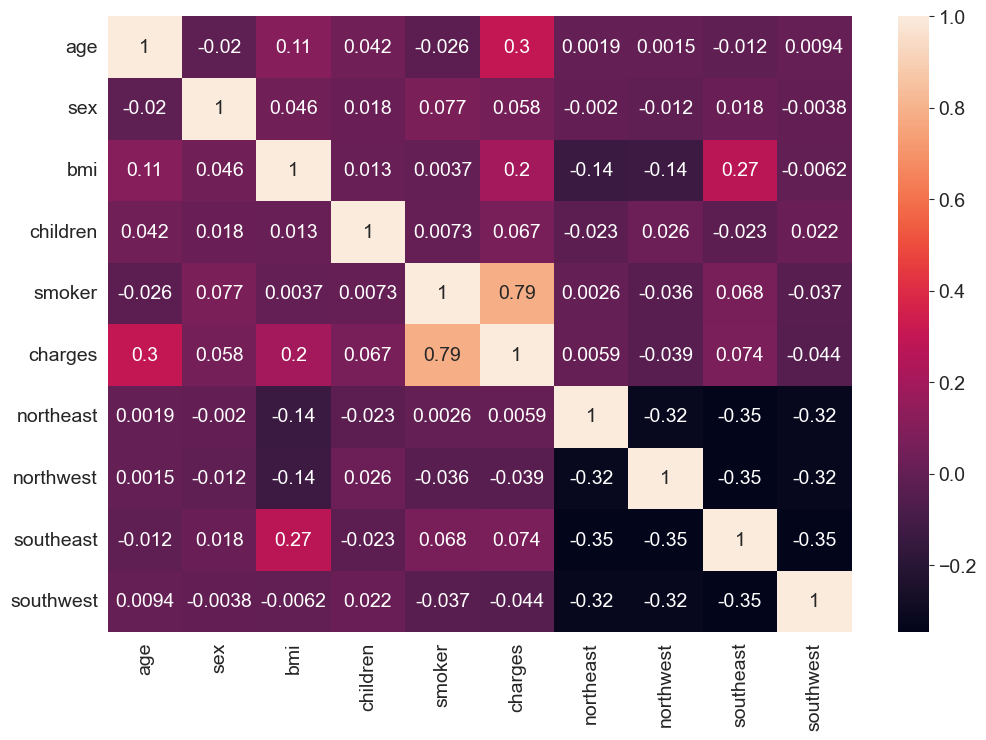

<Figure size 800x500 with 0 Axes>

In [31]:
more_features_included = medical_df.drop('region', axis = 1)
sns.heatmap(more_features_included.corr(), annot = True)
plt.figure(figsize = (8,5))
plt.show()

From here we can also observe that my target variable `charges` depends a lot on "smoker", "age" and "bmi" (in this order). 

### Standarization
A column with a large range of inputs may disproportionately affect the RSME and dominate the optimization process. For this reason it's a common practice to scale (i.e to standardize) the values in numeric column by substracting the mean and dividing by the standard deviation.
![](StandardizationFormula.png)

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
numerical_columns

age     bmi  children      charges
0      19  27.900         0  16884.92400
1      18  33.770         1   1725.55230
2      28  33.000         3   4449.46200
3      33  22.705         0  21984.47061
4      32  28.880         0   3866.85520
...   ...     ...       ...          ...
1333   50  30.970         3  10600.54830
1334   18  31.920         0   2205.98080
1335   18  36.850         0   1629.83350
1336   21  25.800         0   2007.94500
1337   61  29.070         0  29141.36030

[1337 rows x 4 columns]

Except of my target variable I want to standardize the remaining numerical columns.

In [34]:
numerical_columns2 = ['age', 'bmi', 'children']
scaler = StandardScaler()
scaler.fit(medical_df[numerical_columns2])
scaled_cols = scaler.transform(medical_df[numerical_columns2])

scaled_cols

array([[-1.44041773, -0.45315959, -0.90923416],
       [-1.51164747,  0.50942165, -0.07944162],
       [-0.79935006,  0.3831546 ,  1.58014347],
       ...,
       [-1.51164747,  1.01448983, -0.90923416],
       [-1.29795825, -0.79752426, -0.90923416],
       [ 1.55123139, -0.26129928, -0.90923416]])

In [35]:
categoric_cols = ['smoker', 'sex', 'northeast', 'northwest', 'southeast', 'southwest']
categorical_data = medical_df[categoric_cols].values

In [36]:
inputs = np.concatenate((scaled_cols, categorical_data), axis = 1) # concatenate them along the columns axis
target = medical_df['charges']

# Applying Machine Learning Algorithms

## Linear Regression 
We saw earlier that age and smoking status influence mostly the medical charges. Therefore I assume the following relationship between them:

From the *Linear-Regression* model we know the formula: Y = a * x + b
==> I'll try to determine Y and b for the line that best feets the data. 
- charges = a * age + b
- charges = a * smoker + b

Then we evaluate the performance of our regression model with a commonly used metric in machine learning: RMSE or also called Loss => it indicates how bad the model is at predicting the target variable. The lower the RMSE, the better the model.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.2, random_state = 42)

In [38]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
r_squared = lr_model.score(X_test, y_test)
y_pred = lr_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)

print(f'The RMSE of the model is: {rmse}')
print(f'The R-square of the model is: {r_squared}')

The RMSE of the model is: 5956.342894363583
The R-square of the model is: 0.8069287081198016


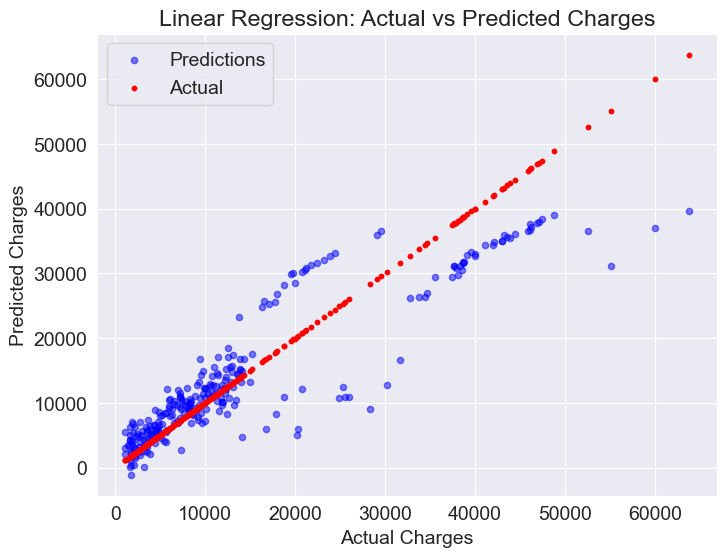

<Figure size 600x400 with 0 Axes>

In [39]:
# Scatter plot of actual vs predicted values in case of Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions', s=20, alpha=0.5)
plt.scatter(y_test, y_test, color='red', label='Actual', s=10)

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Linear Regression: Actual vs Predicted Charges')
plt.legend()
plt.figure(figsize = (6,4))
plt.show()

## Random Forest Regressor
- This model constructs multiple decision trees during training and outputs the average prediction of the individual trees. In other words RandomForestRegressor aggregates predictions from multiple decision trees, resulting in improved performance and robustness against overfitting.
- It's suitable for both regression and classification tasks and can handle non-linear relationships between the features and the target.

In [40]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
r_squared2 = rf_model.score(X_test, y_test)
y_pred2 = rf_model.predict(X_test)
rmse2 = mean_squared_error(y_test, y_pred2, squared = False)

print(f'The RMSE of the model is: {rmse2}')
print(f'The R-square of the model is: {r_squared2}')

The RMSE of the model is: 4677.005276906449
The R-square of the model is: 0.8809596925447952


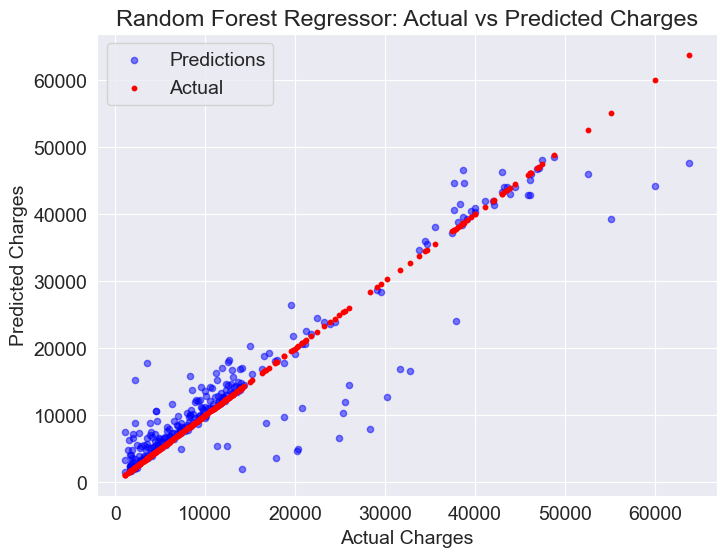

In [41]:
# Scatter plot of actual vs predicted values in case of Random Forest Regressor
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred2, color='blue', label='Predictions', s=20, alpha=0.5)
plt.scatter(y_test, y_test, color='red', label='Actual', s=10)

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Random Forest Regressor: Actual vs Predicted Charges')
plt.legend()
plt.show()